In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree, export_text
from sklearn.ensemble import HistGradientBoostingClassifier  

# Configuración de visualización
sns.set(style="whitegrid")

# Carga y Exploración de Datos

In [2]:
# Carga de datos
df = pd.read_csv('C:/Users/Gerardo_PC/Desktop/DS4Business - Data Scientist/07_PortfolioDS/01_AbandonoEmpleados/00_Dataset/AbandonoEmpleados.csv',
               sep=';',
               index_col='id')

In [3]:
display(df.info())
display(df.head())
display(df.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   object 
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1470 non-null   object 
 6   carrera                   1470 non-null   object 
 7   empleados                 1470 non-null   int64  
 8   satisfaccion_entorno      1470 non-null   object 
 9   sexo                      1271 non-null   float64
 10  implicacion               1470 non-null   object 
 11  nivel_laboral             1470 non-null   int64  
 12  puesto                    1470 non-null   object 
 13  satisfaccion_trabajo      1470 non-null   object 
 14  estado_civil 

None

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,empleados,satisfaccion_entorno,sexo,...,satisfaccion_companeros,horas_quincena,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,conciliacion,anos_compania,anos_en_puesto,anos_desde_ult_promocion,anos_con_manager_actual
id,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,Sales,1,Universitaria,Life Sciences,1,Media,3.0,...,Baja,80,0,8,0,#N/D,6,NaN,0,5
2,49,No,Travel_Frequently,Research & Development,8,Secundaria,Life Sciences,1,Alta,2.0,...,Muy_Alta,80,1,10,3,#N/D,10,NaN,1,7
4,37,Yes,Travel_Rarely,Research & Development,2,Secundaria,Other,1,Muy_Alta,2.0,...,Media,80,0,7,3,#N/D,0,2.0,0,0
5,33,No,Travel_Frequently,Research & Development,3,Universitaria,Life Sciences,1,Muy_Alta,3.0,...,Alta,80,0,8,3,#N/D,8,3.0,3,0
7,27,No,Travel_Rarely,Research & Development,2,Universitaria,Medical,1,Baja,3.0,...,Muy_Alta,80,1,6,3,#N/D,2,NaN,2,2


Index(['edad', 'abandono', 'viajes', 'departamento', 'distancia_casa',
       'educacion', 'carrera', 'empleados', 'satisfaccion_entorno', 'sexo',
       'implicacion', 'nivel_laboral', 'puesto', 'satisfaccion_trabajo',
       'estado_civil', 'salario_mes', 'num_empresas_anteriores', 'mayor_edad',
       'horas_extra', 'incremento_salario_porc', 'evaluacion',
       'satisfaccion_companeros', 'horas_quincena', 'nivel_acciones',
       'anos_experiencia', 'num_formaciones_ult_ano', 'conciliacion',
       'anos_compania', 'anos_en_puesto', 'anos_desde_ult_promocion',
       'anos_con_manager_actual'],
      dtype='object')

## Análisis de Valores Faltantes

In [4]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'Valores Faltantes', 1: '% del Total'})
    return mis_val_table[mis_val_table['Valores Faltantes'] > 0]

display(missing_values_table(df))

,Valores Faltantes,% del Total
sexo,199,13.537415
anos_en_puesto,1238,84.217687


In [5]:
df.drop(columns = ['anos_en_puesto','sexo'], inplace = True)
df.head(10)

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,empleados,satisfaccion_entorno,implicacion,...,evaluacion,satisfaccion_companeros,horas_quincena,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,conciliacion,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual
id,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,Sales,1,Universitaria,Life Sciences,1,Media,Alta,...,Alta,Baja,80,0,8,0,#N/D,6,0,5
2,49,No,Travel_Frequently,Research & Development,8,Secundaria,Life Sciences,1,Alta,Media,...,Muy_Alta,Muy_Alta,80,1,10,3,#N/D,10,1,7
4,37,Yes,Travel_Rarely,Research & Development,2,Secundaria,Other,1,Muy_Alta,Media,...,Alta,Media,80,0,7,3,#N/D,0,0,0
5,33,No,Travel_Frequently,Research & Development,3,Universitaria,Life Sciences,1,Muy_Alta,Alta,...,Alta,Alta,80,0,8,3,#N/D,8,3,0
7,27,No,Travel_Rarely,Research & Development,2,Universitaria,Medical,1,Baja,Alta,...,Alta,Muy_Alta,80,1,6,3,#N/D,2,2,2
8,32,No,Travel_Frequently,Research & Development,2,Universitaria,Life Sciences,1,Muy_Alta,Alta,...,Alta,Alta,80,0,8,2,#N/D,7,3,6
10,59,No,Travel_Rarely,Research & Development,3,Master,Medical,1,Alta,Muy_Alta,...,Muy_Alta,Baja,80,3,12,3,Muy_Alta,1,0,0
11,30,No,Travel_Rarely,Research & Development,24,Universitaria,Life Sciences,1,Muy_Alta,Alta,...,Muy_Alta,Media,80,1,1,2,#N/D,1,0,0
12,38,No,Travel_Frequently,Research & Development,23,Secundaria,Life Sciences,1,Muy_Alta,Media,...,Muy_Alta,Media,80,0,10,2,#N/D,9,1,8


# Análisis Exploratorio de Datos (EDA)

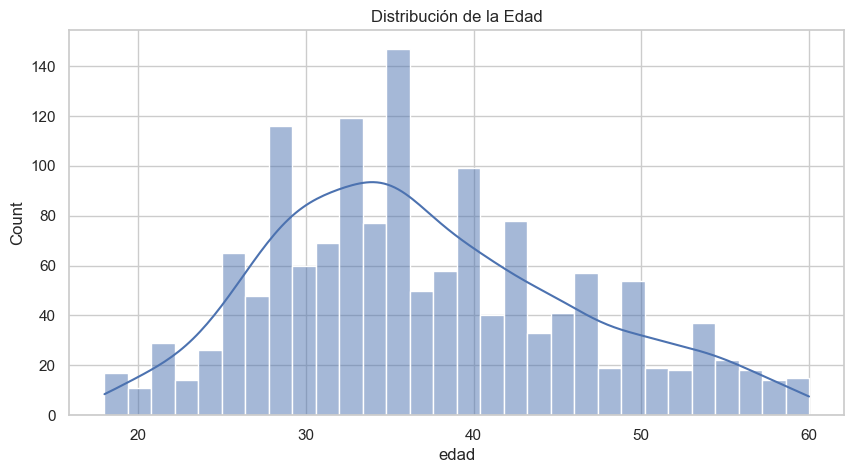

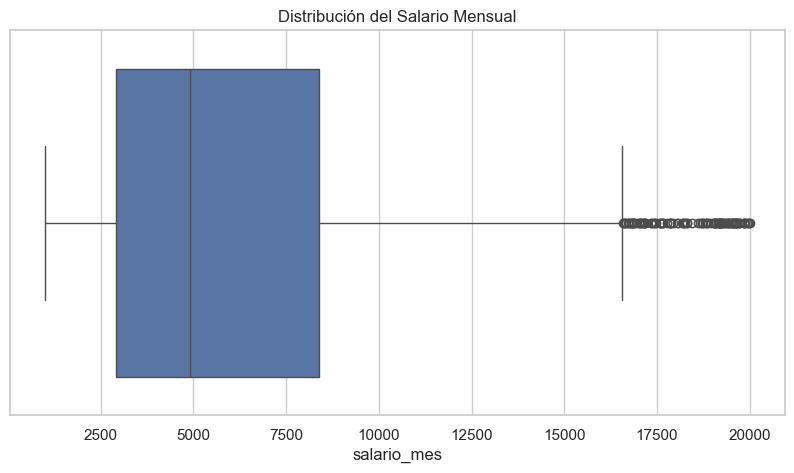

In [6]:
# Visualizamos distribuciones y relaciones clave en los datos.
plt.figure(figsize=(10,5))
sns.histplot(df['edad'], bins=30, kde=True)
plt.title('Distribución de la Edad')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['salario_mes'])
plt.title('Distribución del Salario Mensual')
plt.show()

## Visualización de Variables Categoricas

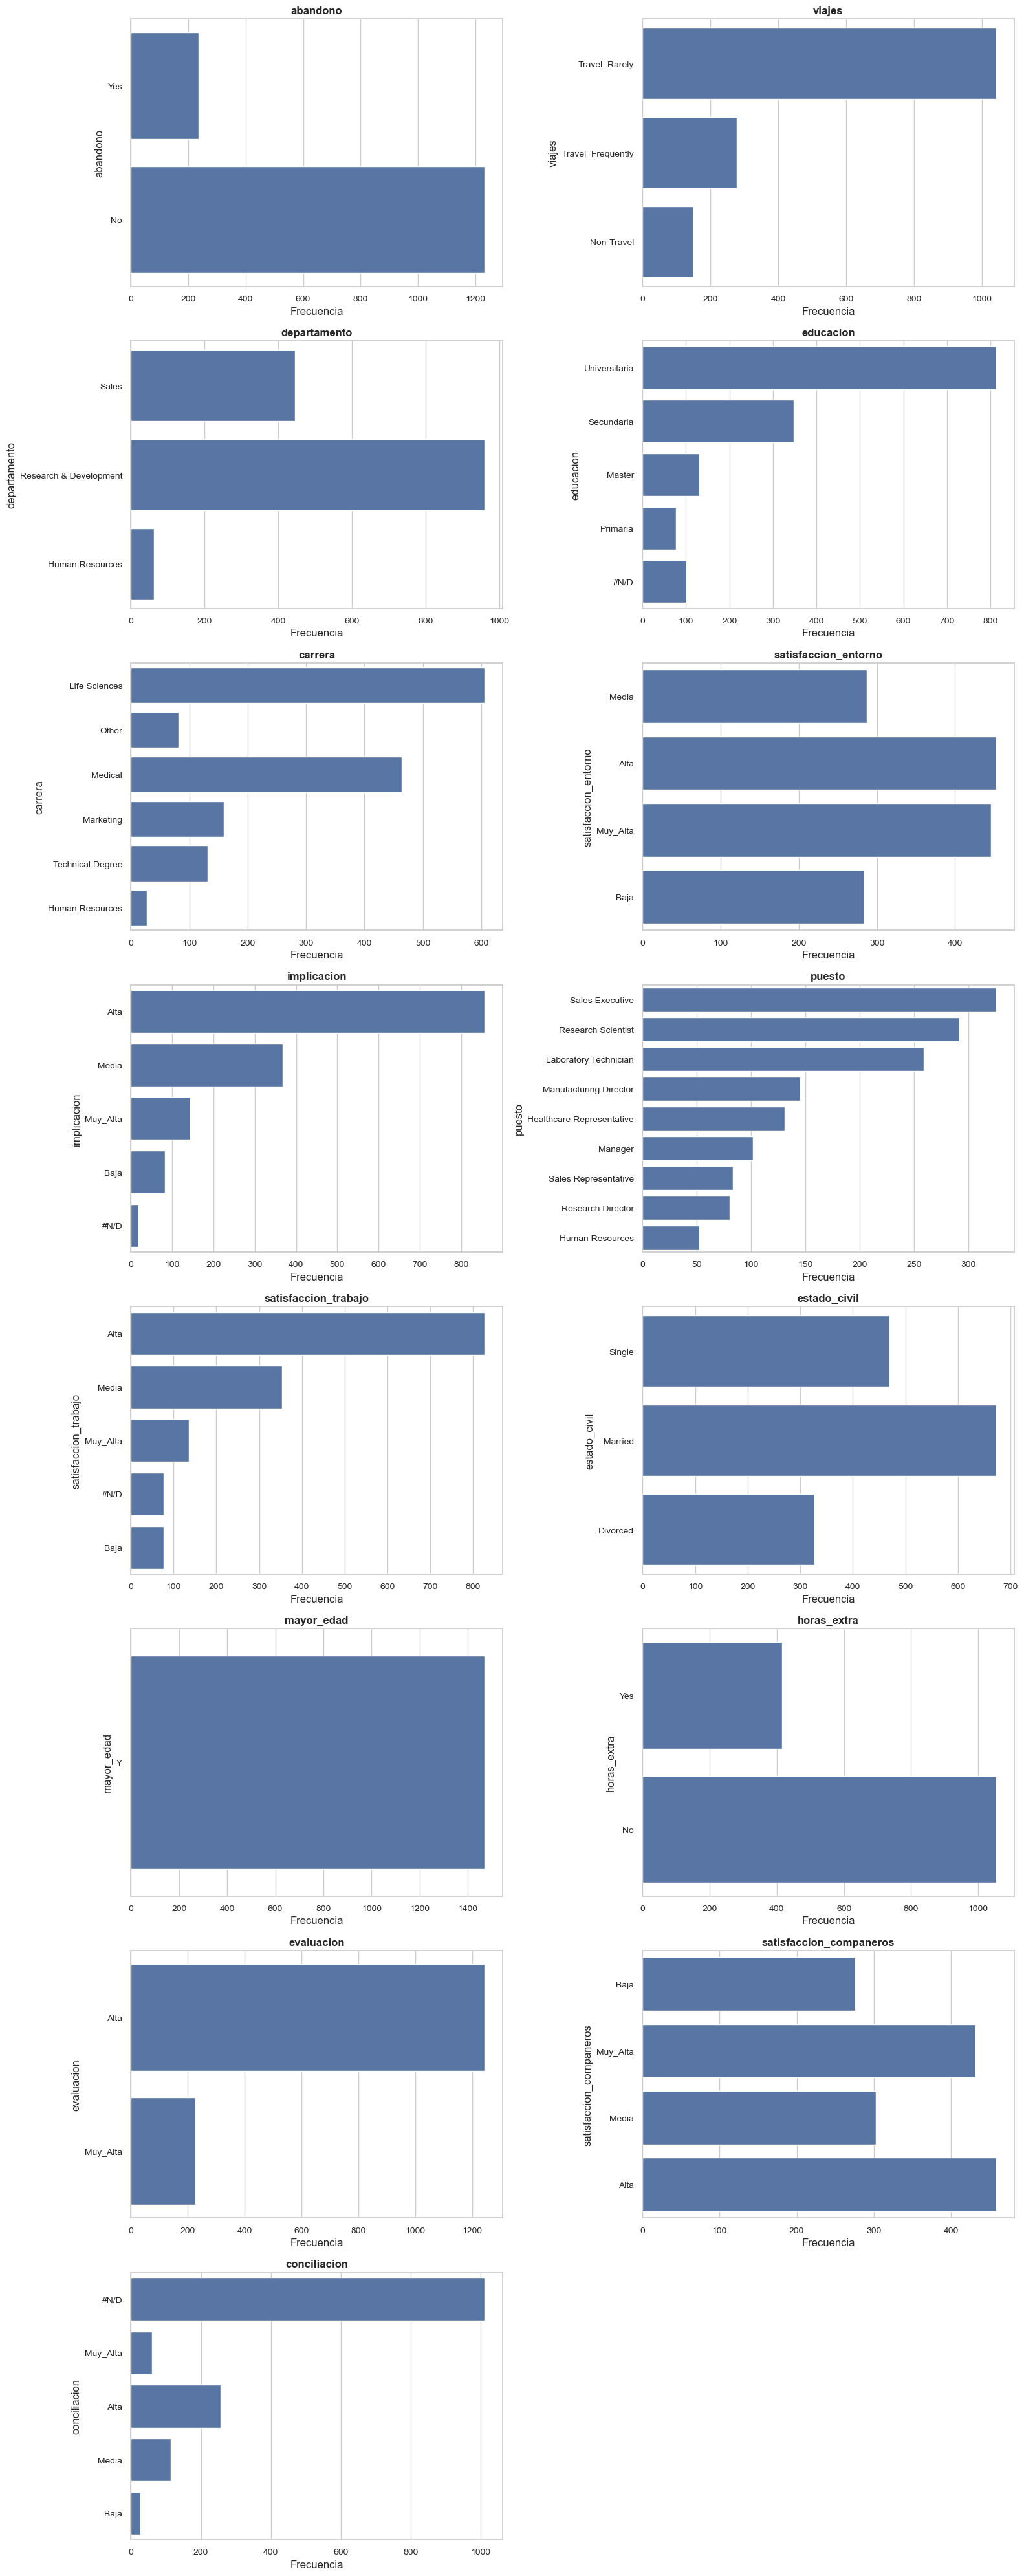

In [7]:
from math import ceil

def graficos_eda_categoricos(cat_df):
    """
    Genera gráficos de barras horizontales para variables categóricas.
    
    Parámetros:
    cat_df (DataFrame): DataFrame con solo variables categóricas.
    """
    if cat_df.shape[1] == 0:
        print("No hay variables categóricas en el DataFrame.")
        return
    
    num_vars = cat_df.shape[1]  # Número de variables categóricas
    filas = ceil(num_vars / 2)   # Cantidad de filas necesarias

    fig, ax = plt.subplots(nrows=filas, ncols=2, figsize=(16, filas * 5))
    ax = ax.flatten()  # Aplanar para iterar fácilmente

    for i, col in enumerate(cat_df.columns):
        sns.countplot(y=cat_df[col], ax=ax[i])
        ax[i].set_title(col, fontsize=12, fontweight="bold")
        ax[i].tick_params(labelsize=10)
        ax[i].set_xlabel("Frecuencia")
        ax[i].set_ylabel(col)

    # Ocultar los ejes vacíos en caso de número impar de gráficos
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    
    plt.tight_layout()
    plt.show()

# Aplicación de la función al DataFrame con variables categóricas
graficos_eda_categoricos(df.select_dtypes(include=['object']))



## Visualización de Variables Numéricas

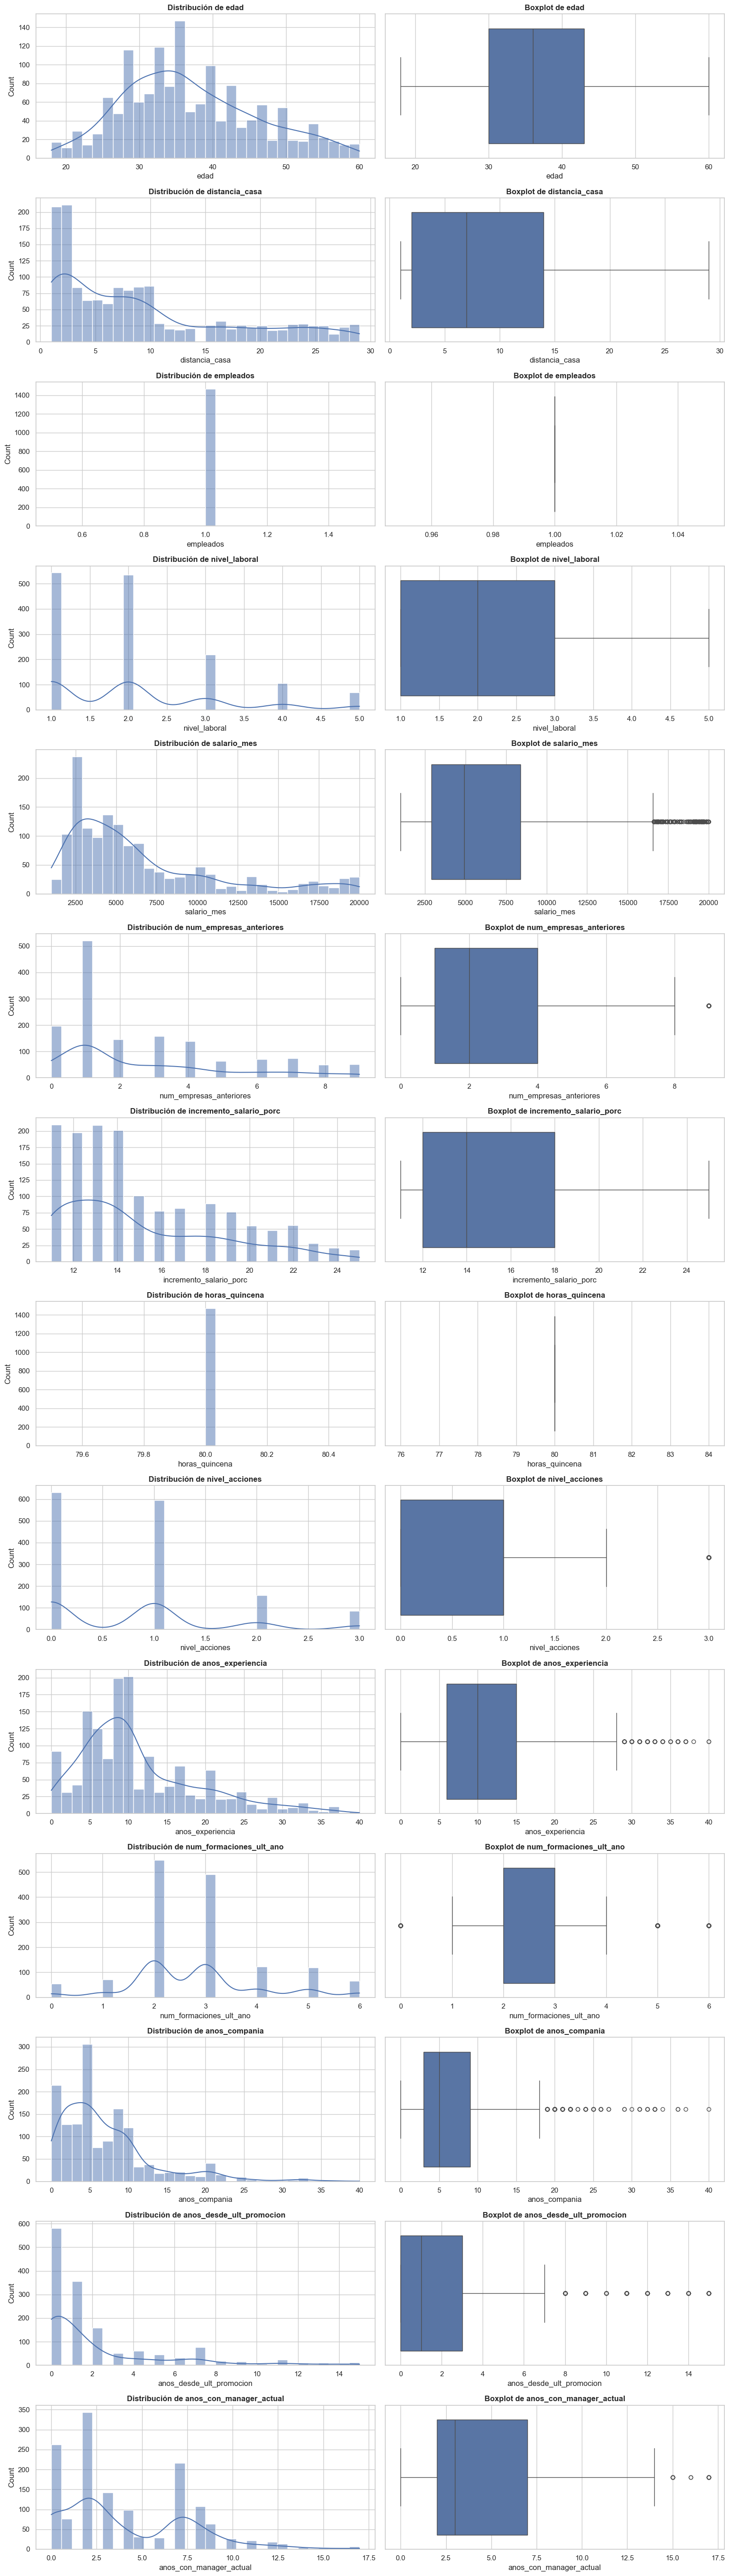

In [8]:
def graficos_eda_numericos(df_numerico):
    if df_numerico.shape[1] == 0:
        print("No hay variables numéricas para graficar.")
        return
    
    filas = len(df_numerico.columns)
    fig, ax = plt.subplots(nrows=filas, ncols=2, figsize=(16, filas * 4))
    ax = ax.flatten()
    
    for i, col in enumerate(df_numerico.columns):
        sns.histplot(df_numerico[col], bins=30, kde=True, ax=ax[i*2])
        ax[i*2].set_title(f'Distribución de {col}', fontsize=12, fontweight='bold')
        sns.boxplot(x=df_numerico[col], ax=ax[i*2+1])
        ax[i*2+1].set_title(f'Boxplot de {col}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

graficos_eda_numericos(df.select_dtypes(include=['number']))

# Business Analytics e Insights

## Cuantificación del problema: ¿Cuál es la tasa de abandono?

In [9]:
df['abandono'] = df.abandono.map({'No':0, 'Yes':1})
abandono_rate = df['abandono'].mean() * 100
print(f"Tasa de abandono: {abandono_rate:.2f}%")

Tasa de abandono: 16.12%


## ¿Hay un perfil tipo de empleado que deja la empresa?

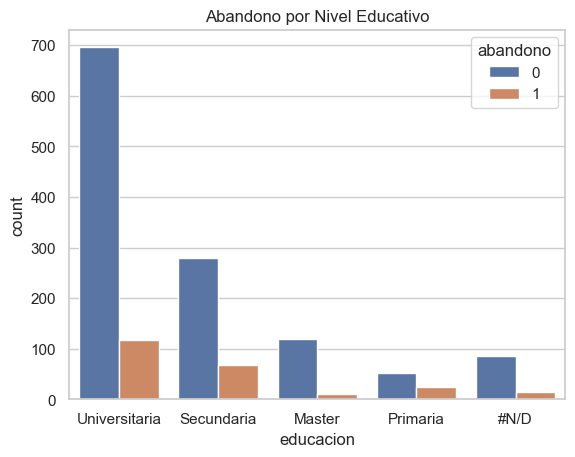

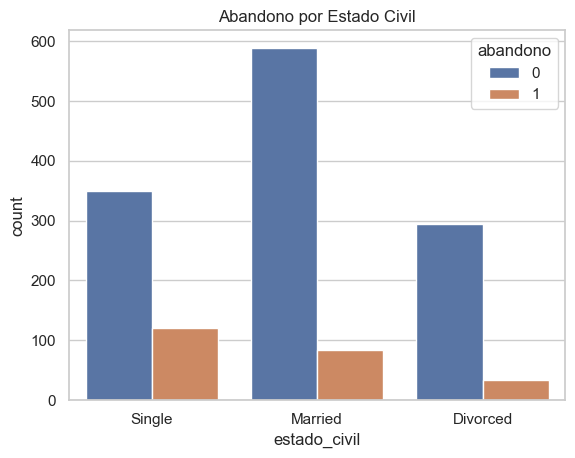

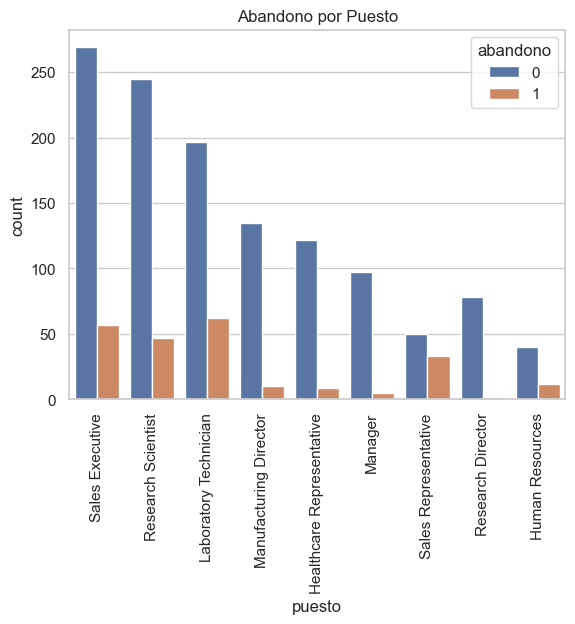

In [10]:
# Análisis por educación
sns.countplot(x='educacion', hue='abandono', data=df)
plt.title("Abandono por Nivel Educativo")
plt.show()

# Análisis por estado civil
sns.countplot(x='estado_civil', hue='abandono', data=df)
plt.title("Abandono por Estado Civil")
plt.show()

# Análisis por puesto
sns.countplot(x='puesto', hue='abandono', data=df)
plt.title("Abandono por Puesto")
plt.xticks(rotation=90)
plt.show()


## Limpieza de Datos

In [11]:
df = pd.get_dummies(df, drop_first=True)

## Análisis de Correlaciones

In [12]:
corr_matrix = df.corr().abs()
corr_unstacked = corr_matrix.unstack().sort_values(ascending=False)
corr_unstacked = corr_unstacked[corr_unstacked < 1].reset_index()
corr_unstacked.columns = ['Variable 1', 'Variable 2', 'Correlación']
top_10_corr = corr_unstacked.head(10)

display(top_10_corr)  # Muestra las 10 correlaciones más altas

,Variable 1,Variable 2,Correlación
0,implicacion_Media,satisfaccion_trabajo_Media,0.974622
1,satisfaccion_trabajo_Media,implicacion_Media,0.974622
2,implicacion_Muy_Alta,satisfaccion_trabajo_Muy_Alta,0.968907
3,satisfaccion_trabajo_Muy_Alta,implicacion_Muy_Alta,0.968907
4,educacion_Secundaria,implicacion_Media,0.963740
5,implicacion_Media,educacion_Secundaria,0.963740
6,educacion_Primaria,implicacion_Baja,0.961101
7,implicacion_Baja,educacion_Primaria,0.961101
8,satisfaccion_trabajo_Alta,implicacion_Alta,0.960478
9,implicacion_Alta,satisfaccion_trabajo_Alta,0.960478


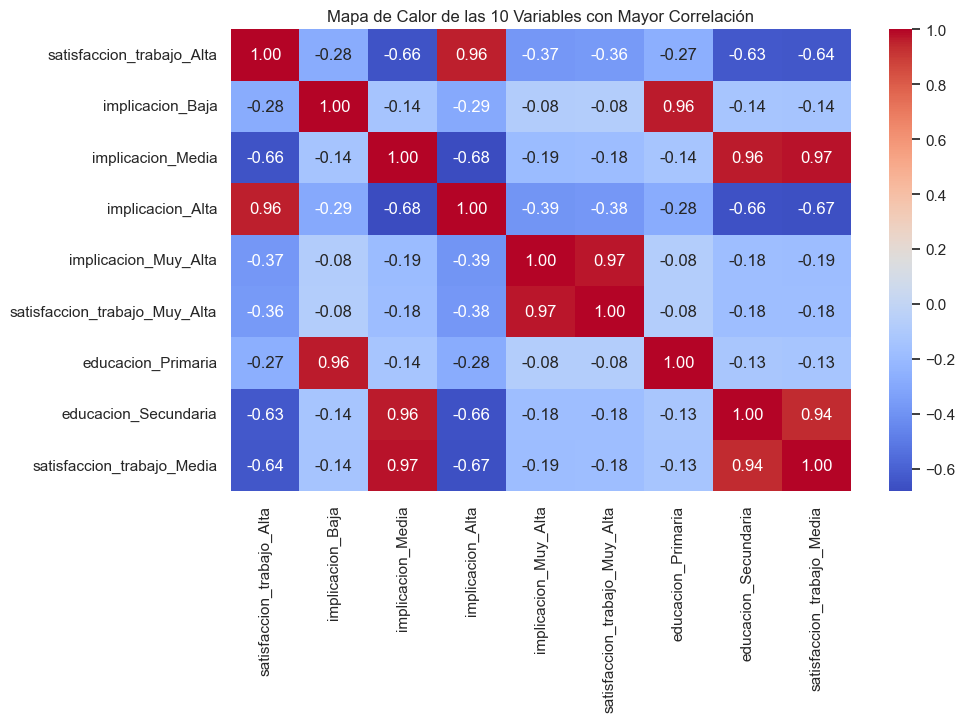

In [13]:
# Se genera un mapa de calor para visualizar las correlaciones entre variables.

# Filtrar solo las variables más correlacionadas
variables_correlacionadas = list(set(top_10_corr['Variable 1']).union(set(top_10_corr['Variable 2'])))
corr_top_10 = df[variables_correlacionadas].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_top_10, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Mapa de Calor de las 10 Variables con Mayor Correlación')
plt.show()

# Conclusiones y Recomendaciones

In [14]:
# Se presentan observaciones y posibles mejoras en base a los análisis realizados.

print("\nConclusiones:\n")
print("- Se observó una variabilidad significativa en salarios y niveles de experiencia.")
print("- Algunas variables pueden estar correlacionadas con la permanencia en la empresa.")
print("- Se recomienda investigar más sobre la satisfacción laboral y conciliación.")


Conclusiones:

- Se observó una variabilidad significativa en salarios y niveles de experiencia.
- Algunas variables pueden estar correlacionadas con la permanencia en la empresa.
- Se recomienda investigar más sobre la satisfacción laboral y conciliación.


# Modelado Predictivo: Predicción de Abandono

## Modelos: Random Forest, Gradient Boosting, SVM

In [28]:
'''
No utilizamos este código ya que SVM demora mucho

if 'abandono' in df.columns:
    df = df.dropna(subset=['abandono'])
    df['abandono'] = df['abandono'].astype(int)
    X = df.drop(columns=['abandono'])
    y = df['abandono']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    models = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "SVM": SVC(probability=True)
    }
    
    param_grids = {
        "Random Forest": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "Gradient Boosting": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        },
        "SVM": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
    
    best_models = {}
    for model_name, model in models.items():
        print(f"\nProbando {model_name}...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
    
    for model_name, best_model in best_models.items():
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        print(f"\nResultados para {model_name}:")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, y_pred))
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend()
        plt.show()
   
else:
    print("Error: La columna 'abandono' no se encuentra en el DataFrame.")
'''

'\nif \'abandono\' in df.columns:\n    df = df.dropna(subset=[\'abandono\'])\n    df[\'abandono\'] = df[\'abandono\'].astype(int)\n    X = df.drop(columns=[\'abandono\'])\n    y = df[\'abandono\']\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n    \n    models = {\n        "Random Forest": RandomForestClassifier(),\n        "Gradient Boosting": GradientBoostingClassifier(),\n        "SVM": SVC(probability=True)\n    }\n    \n    param_grids = {\n        "Random Forest": {\n            \'n_estimators\': [100, 200, 300],\n            \'max_depth\': [None, 10, 20],\n            \'min_samples_split\': [2, 5]\n        },\n        "Gradient Boosting": {\n            \'n_estimators\': [100, 200],\n            \'learning_rate\': [0.01, 0.1, 0.2],\n            \'max_depth\': [3, 5]\n        },\n        "SVM": {\n            \'C\': [0.1, 1, 10],\n            \'kernel\': [\'linear\', \'rbf\']\n        }\n    }\n    \n    best_models = {

## Modelos: Random Forest, Gradient Boosting, XGBoost, LigthGBM


Probando Random Forest...
Mejores hiperparámetros para Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
AUC para Random Forest: 0.7877

Probando Gradient Boosting...
Mejores hiperparámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
AUC para Gradient Boosting: 0.8012

Probando XGBoost...
Mejores hiperparámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}
AUC para XGBoost: 0.7699

Probando LightGBM...
Mejores hiperparámetros para LightGBM: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
AUC para LightGBM: 0.7762

El mejor modelo es:
Modelo: Gradient Boosting
AUC: 0.8012
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Resultados para Random Forest:
Matriz de Confusión:
[[240   7]
 [ 41   6]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1    

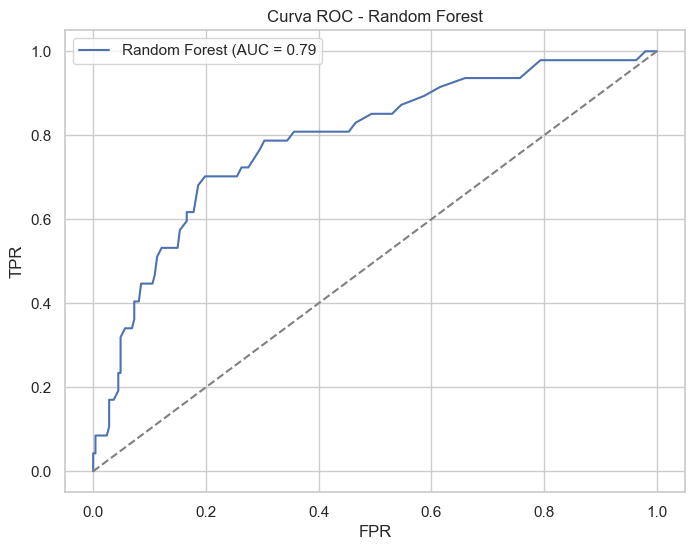


Resultados para Gradient Boosting:
Matriz de Confusión:
[[238   9]
 [ 35  12]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       247
           1       0.57      0.26      0.35        47

    accuracy                           0.85       294
   macro avg       0.72      0.61      0.63       294
weighted avg       0.82      0.85      0.83       294



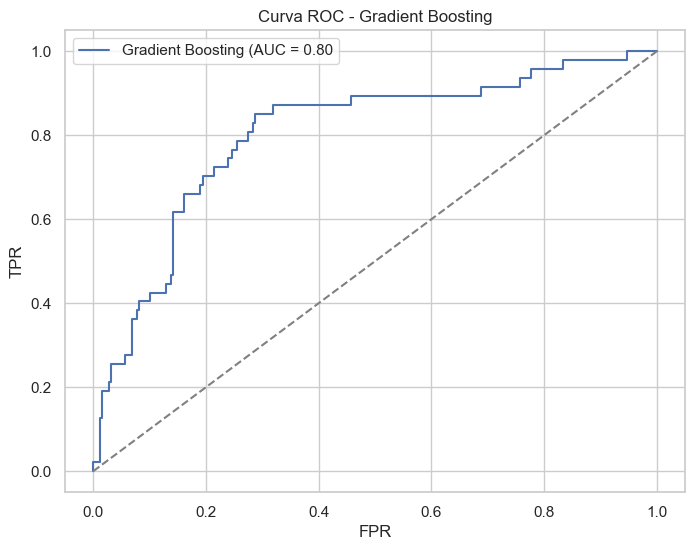


Resultados para XGBoost:
Matriz de Confusión:
[[236  11]
 [ 34  13]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.54      0.28      0.37        47

    accuracy                           0.85       294
   macro avg       0.71      0.62      0.64       294
weighted avg       0.82      0.85      0.83       294



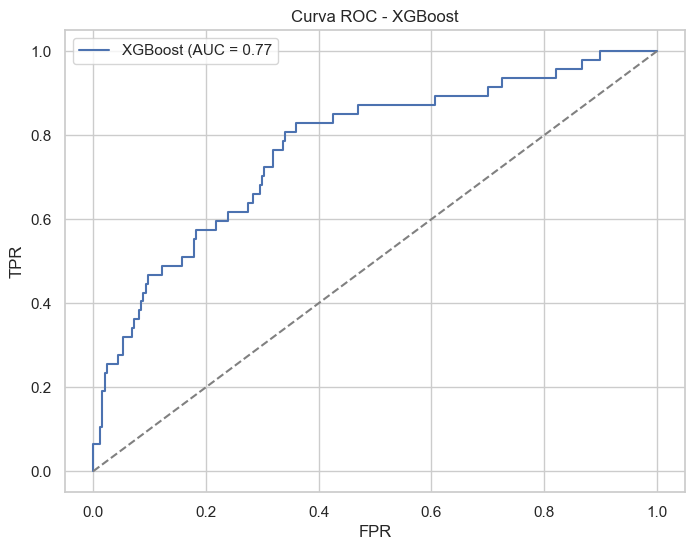


Resultados para LightGBM:
Matriz de Confusión:
[[237  10]
 [ 34  13]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       247
           1       0.57      0.28      0.37        47

    accuracy                           0.85       294
   macro avg       0.72      0.62      0.64       294
weighted avg       0.83      0.85      0.83       294



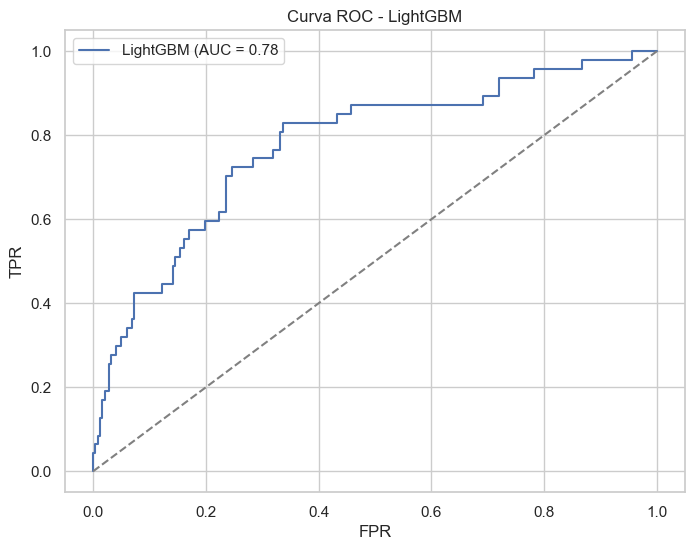

In [26]:
if 'abandono' in df.columns:
    df = df.dropna(subset=['abandono'])
    df['abandono'] = df['abandono'].astype(int)
    X = df.drop(columns=['abandono'])
    y = df['abandono']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    models = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "XGBoost": HistGradientBoostingClassifier(),
        "LightGBM": LGBMClassifier(verbose=-1)
    }

    
    param_grids = {
        "Random Forest": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "Gradient Boosting": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        },
        "XGBoost": {
            'max_iter': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        },
        "LightGBM": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        }
    }
    
    best_models = {}
    best_auc = 0
    best_model_name = None
    best_model_params = None
    
    for model_name, model in models.items():
        print(f"\nProbando {model_name}...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', error_score='raise')
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
        
        y_pred_proba = best_models[model_name].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC para {model_name}: {roc_auc:.4f}")
        
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_model_name = model_name
            best_model_params = grid_search.best_params_
    
    print("\nEl mejor modelo es:")
    print(f"Modelo: {best_model_name}")
    print(f"AUC: {best_auc:.4f}")
    print(f"Mejores hiperparámetros: {best_model_params}")
    
    for model_name, best_model in best_models.items():
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        print(f"\nResultados para {model_name}:")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, y_pred))
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend()
        plt.show()
    
else:
    print("Error: La columna 'abandono' no se encuentra en el DataFrame.")

## Modelos: Random Forest, Gradient Boosting, SVM - Graficos Unificados


Probando Random Forest...
Mejores hiperparámetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
AUC para Random Forest: 0.7841

Probando Gradient Boosting...
Mejores hiperparámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
AUC para Gradient Boosting: 0.8011

Probando XGBoost...
Mejores hiperparámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}
AUC para XGBoost: 0.7699

Probando LightGBM...
Mejores hiperparámetros para LightGBM: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
AUC para LightGBM: 0.7762


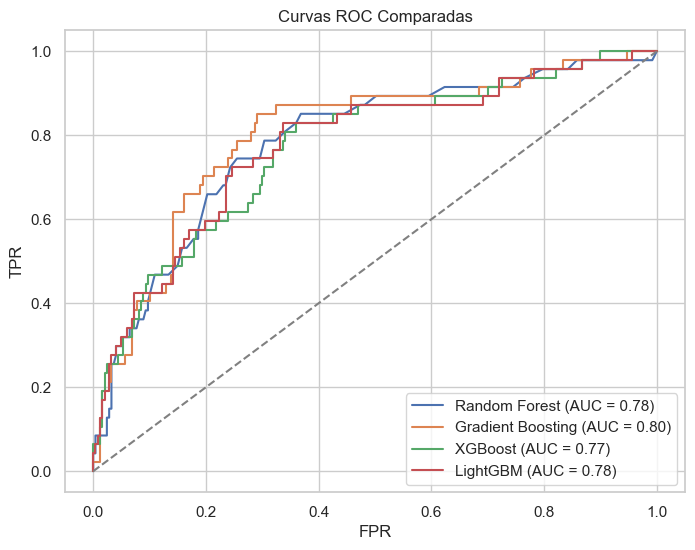


El mejor modelo es:
Modelo: Gradient Boosting
AUC: 0.8011
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Resultados para Random Forest:
Matriz de Confusión:
[[241   6]
 [ 43   4]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.40      0.09      0.14        47

    accuracy                           0.83       294
   macro avg       0.62      0.53      0.52       294
weighted avg       0.78      0.83      0.79       294


Resultados para Gradient Boosting:
Matriz de Confusión:
[[238   9]
 [ 35  12]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       247
           1       0.57      0.26      0.35        47

    accuracy                           0.85       294
   macro avg       0.72      0.61      0.63       294
weighted avg       0.82      0.85      0.83    

In [27]:
'''
Mismo código que el anterior, pero con graficos unificados:
'''
if 'abandono' in df.columns:
    df = df.dropna(subset=['abandono'])
    df['abandono'] = df['abandono'].astype(int)
    X = df.drop(columns=['abandono'])
    y = df['abandono']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    models = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "XGBoost": HistGradientBoostingClassifier(),
        "LightGBM": LGBMClassifier()
    }
    
    param_grids = {
        "Random Forest": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "Gradient Boosting": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        },
         "XGBoost": {
            'max_iter': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        },
        "LightGBM": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        }
    }
    
    best_models = {}
    best_auc = 0
    best_model_name = None
    best_model_params = None
    
    plt.figure(figsize=(8, 6))
    
    for model_name, model in models.items():
        print(f"\nProbando {model_name}...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
        
        y_pred_proba = best_models[model_name].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC para {model_name}: {roc_auc:.4f}")
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_model_name = model_name
            best_model_params = grid_search.best_params_
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curvas ROC Comparadas')
    plt.legend()
    plt.show()
    
    print("\nEl mejor modelo es:")
    print(f"Modelo: {best_model_name}")
    print(f"AUC: {best_auc:.4f}")
    print(f"Mejores hiperparámetros: {best_model_params}")
    
    for model_name, best_model in best_models.items():
        y_pred = best_model.predict(X_test)
        print(f"\nResultados para {model_name}:")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, y_pred))
else:
    print("Error: La columna 'abandono' no se encuentra en el DataFrame.")

,Variable,Importancia
4,salario_mes,103
0,edad,47
1,distancia_casa,45
48,horas_extra_Yes,43
5,num_empresas_anteriores,40
8,nivel_acciones,33
13,anos_con_manager_actual,30
12,anos_desde_ult_promocion,22
14,viajes_Travel_Frequently,22
27,satisfaccion_entorno_Baja,21


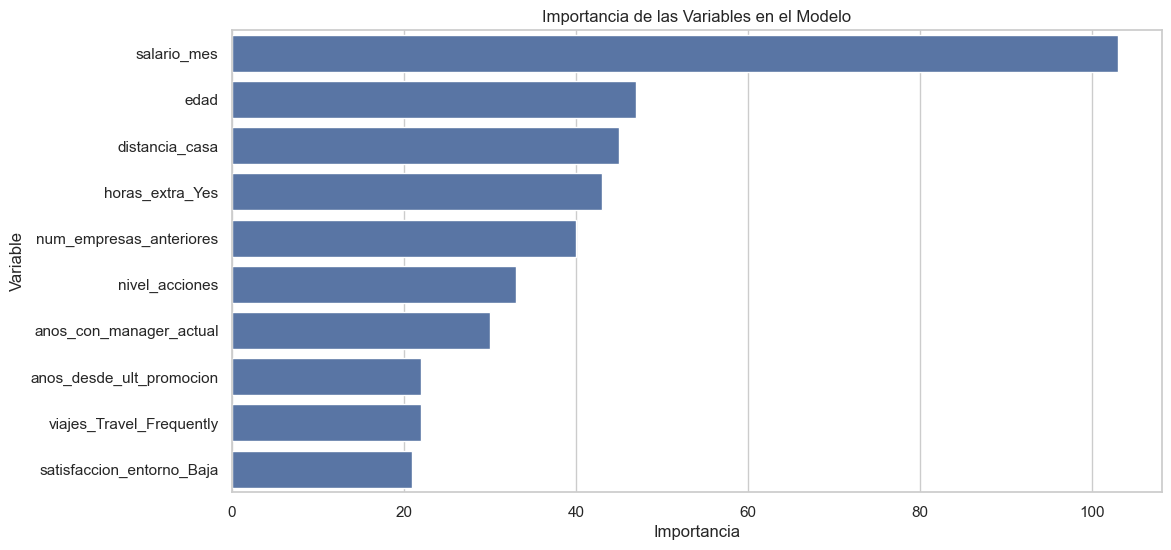

In [32]:
# Obtener la importancia de las variables en el modelo
importances = best_model.feature_importances_
feature_names = X.columns

# Crear un DataFrame con la importancia de cada variable
feature_importance_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Ordenar de mayor a menor importancia
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Mostrar la tabla
display(feature_importance_df)

# Visualización de la importancia de las variables
plt.figure(figsize=(12, 6))
sns.barplot(x='Importancia', y='Variable', data=feature_importance_df.head(10))
plt.title('Importancia de las Variables en el Modelo')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()


In [33]:
# Obtener el scoring de predicción (probabilidad de abandono)
df['score_abandono'] = best_model.predict_proba(X)[:, 1]

# Mostrar las primeras filas con el scoring agregado
display(df[['abandono', 'score_abandono']].head())


,abandono,score_abandono
id,,
1,1,0.581111
2,0,0.020866
4,1,0.639697
5,0,0.439205
7,0,0.164154


In [34]:
# Obtener la probabilidad de abandono para cada empleado
df['score_abandono'] = best_model.predict_proba(X)[:, 1]

# Mostrar los 10 empleados con mayor probabilidad de abandono con todas sus características
top_10_abandono = df.sort_values(by='score_abandono', ascending=False).head(10)

# Mostrar la tabla completa de los empleados con mayor probabilidad de abandonar
display(top_10_abandono)

# Guardar el DataFrame con la nueva columna en un archivo CSV
df.to_csv("dataset_con_scoring_GirdSearch.csv", index=False)
print("El archivo 'dataset_con_scoring_hiperparametros.csv' ha sido guardado con éxito.")

,edad,abandono,distancia_casa,empleados,nivel_laboral,salario_mes,num_empresas_anteriores,incremento_salario_porc,horas_quincena,nivel_acciones,...,horas_extra_Yes,evaluacion_Muy_Alta,satisfaccion_companeros_Baja,satisfaccion_companeros_Media,satisfaccion_companeros_Muy_Alta,conciliacion_Alta,conciliacion_Baja,conciliacion_Media,conciliacion_Muy_Alta,score_abandono
id,,,,,,,,,,,,,,,,,,,,,
1273,25,1,24,1,1,1118,1,14,80,0,...,True,False,False,False,True,False,True,False,False,0.994261
167,19,1,22,1,1,1675,1,19,80,0,...,True,False,False,False,True,False,False,False,False,0.978675
1944,27,1,22,1,1,2863,1,12,80,0,...,False,False,True,False,False,False,False,False,False,0.977922
622,26,1,24,1,1,2340,1,18,80,0,...,True,False,False,True,False,False,False,False,False,0.975369
1624,18,1,3,1,1,1569,1,12,80,0,...,True,False,False,False,False,False,False,False,False,0.971240
614,18,1,5,1,1,1878,1,14,80,0,...,True,False,False,False,True,False,False,False,False,0.963448
911,32,1,25,1,1,2795,1,24,80,0,...,True,True,False,False,False,True,False,False,False,0.950766
137,20,1,6,1,1,2926,1,18,80,0,...,True,False,False,True,False,False,False,False,False,0.949986
19,28,1,24,1,1,2028,5,14,80,0,...,True,False,False,True,False,False,False,False,False,0.948194


El archivo 'dataset_con_scoring_hiperparametros.csv' ha sido guardado con éxito.


# Costo de Reemplazo y estrategias de retencion

In [35]:
# Obtener la probabilidad de abandono y agregarla al DataFrame
df['score_abandono'] = best_model.predict_proba(X)[:, 1]

# Seleccionar los 10 empleados con mayor riesgo de abandono
top_10_abandono = df.sort_values(by='score_abandono', ascending=False).head(10)

# Calcular el costo de reemplazo (100% del salario anual)
top_10_abandono['costo_reemplazo'] = top_10_abandono['salario_mes'] * 12

# Sumar el costo total si esos empleados se fueran
costo_total_reemplazo = top_10_abandono['costo_reemplazo'].sum()

# Mostrar la tabla con empleados en riesgo y su costo de reemplazo
display(top_10_abandono[['score_abandono', 'salario_mes', 'costo_reemplazo']])

# Guardar el DataFrame actualizado con scoring
df.to_csv("dataset_con_scoringGirdSearch.csv", index=False)

# Imprimir el costo total
print(f"\nCosto total estimado de reemplazo si estos empleados abandonan: ${costo_total_reemplazo:,.2f}")

# %% [markdown]
# # Estrategias de Retención
# Basadas en las variables más influyentes en la predicción de abandono.

print("\nEstrategias de Retención:")
print("- Implementar incrementos salariales estratégicos para los empleados en riesgo.")
print("- Mejorar la conciliación entre la vida laboral y personal (home office, horarios flexibles).")
print("- Ofrecer oportunidades de formación y desarrollo profesional.")
print("- Optimizar las condiciones de trabajo y el ambiente organizacional.")
print("- Diseñar planes de carrera y promociones internas para empleados clave.")

,score_abandono,salario_mes,costo_reemplazo
id,,,
1273,0.994261,1118,13416
167,0.978675,1675,20100
1944,0.977922,2863,34356
622,0.975369,2340,28080
1624,0.971240,1569,18828
614,0.963448,1878,22536
911,0.950766,2795,33540
137,0.949986,2926,35112
19,0.948194,2028,24336



Costo total estimado de reemplazo si estos empleados abandonan: $255,756.00

Estrategias de Retención:
- Implementar incrementos salariales estratégicos para los empleados en riesgo.
- Mejorar la conciliación entre la vida laboral y personal (home office, horarios flexibles).
- Ofrecer oportunidades de formación y desarrollo profesional.
- Optimizar las condiciones de trabajo y el ambiente organizacional.
- Diseñar planes de carrera y promociones internas para empleados clave.


In [37]:
import pickle

# Guardar el modelo entrenado en un archivo .pkl
with open('modelo_GirdSearch.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Modelo guardado exitosamente en 'modelo_GirdSearch.pkl'")

Modelo guardado exitosamente en 'modelo_GirdSearch.pkl'
